# COMP551 Project3 Group11




## Loading data


In [1]:
!pip install tensorflow==1.14
!pip install keras-tuner
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import numpy as np

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)
#examine the dataseet 

     |████████████████████████████████| 109.2MB 87kB/s 
     |████████████████████████████████| 491kB 42.6MB/s 
     |████████████████████████████████| 3.2MB 36.3MB/s 
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3
     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=a569af8384ff26a24442060ebe42b703c851f121e0c87d06a745e049213a2729
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

170500096/170498071 [==============================] - 2s 0us/step
Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


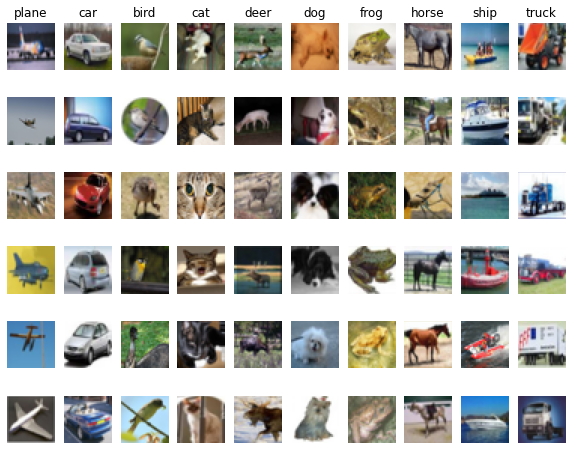

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 6
for label_ind, cls in enumerate(classes):
    idxs = np.where(y_train == label_ind)[0]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + label_ind + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Training

In [4]:
# Preparing the dataset
# Transform label indices to one-hot encoded vectors


# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)
from keras.utils.np_utils import to_categorical
X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train=to_categorical(y_train, num_classes=10)
y_test=to_categorical(y_test, num_classes=10)

X_train /= 255
X_test /= 255
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Using TensorFlow backend.


(50000, 3072)
(50000, 10)
(10000, 3072)
(10000, 10)


In [0]:
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from keras.activations import relu, elu
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time

LOG_DIR=f"{int(time.time())}"
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(hp.Int("input_unit1", 128, 256, 4), activation='relu', input_dim=3072))
    # we can change the 256 to another figure to play with the number of units per layer
    for i in range (hp.Int("n_hidden_layers", 1, 10)):
      model.add(Dense(hp.Int("input_unit2", 128, 256, 4), activation=hp.Choice('activation_type', ['relu'])))
      
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(Dense(256, activation='relu', input_dim=3072))
    model.add(Dense(10, activation='softmax'))
    #opt = SGD(lr=0.001, momentum=0.9)
    #optAdam = Adam()
    model.compile(optimizer="sgd",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

 
tuner = RandomSearch(
    build_model,
    objective = "val_acc",
    max_trials=1,
    executions_per_trial=1,
    directory = LOG_DIR
)

tuner.search(x=X_train, y=y_train, epochs=100, batch_size = 100, validation_split=0.1)
#tuner.search_space_summary()
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 6s 129us/sample - loss: 2.1957 - acc: 0.1863 - val_loss: 2.0147 - val_acc: 0.2702
Epoch 2/100
45000/45000 [==============================] - 6s 122us/sample - loss: 1.9728 - acc: 0.2750 - val_loss: 1.9420 - val_acc: 0.3026
Epoch 3/100
45000/45000 [==============================] - 5s 121us/sample - loss: 1.8780 - acc: 0.3190 - val_loss: 1.9923 - val_acc: 0.2858
Epoch 4/100
45000/45000 [==============================] - 6s 122us/sample - loss: 1.8088 - acc: 0.3494 - val_loss: 1.7494 - val_acc: 0.3704
Epoch 5/100
45000/45000 [==============================] - 6s 122us/sample - loss: 1.7532 - acc: 0.3698 - val_loss: 1.7435 - val_acc: 0.3784
Epoch 6/100
45000/45000 [==============================] - 5s 120us/sample - loss: 1.7071 - acc: 0.3893 - val_loss: 1.6977 - val_acc: 0.3998
Epoch 7/100
45000/45000 [==============================] - 5s 120us/sample - loss: 1.6752 - acc: 0.3990 -

INFO:tensorflow:Oracle triggered exit
10000/10000 [==============================] - 1s 84us/sample - loss: 1.3415 - acc: 0.5256
loss: 1.341461149406433
accuracy: 0.5256
